In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import drive

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Importación de las imágenes

In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/My Drive/Colab Notebooks/train_eyes'
#data_dir = "Data/train_eyes"
batch_size = 16
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1234 files belonging to 2 classes.
Using 988 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1234 files belonging to 2 classes.
Using 246 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Closed', 'Open']


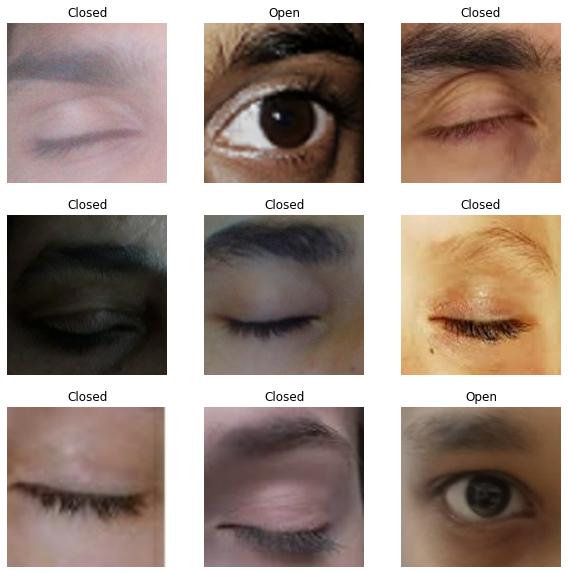

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 180, 180, 3)
(16,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.cache()
val_ds = val_ds.cache()

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

KeyboardInterrupt: ignored

## Creación del modelo

In [13]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(units=100, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0

## Entrenamiento

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
62/62 [==============================] - 62s 818ms/step - loss: 0.6641 - accuracy: 0.7702 - val_loss: 0.2327 - val_accuracy: 0.9065
Epoch 2/10
62/62 [==============================] - 1s 22ms/step - loss: 0.2012 - accuracy: 0.9190 - val_loss: 0.1620 - val_accuracy: 0.9431
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 0.1124 - accuracy: 0.9565 - val_loss: 0.1522 - val_accuracy: 0.9228
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 0.0953 - accuracy: 0.9696 - val_loss: 0.2254 - val_accuracy: 0.9228
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 0.0926 - accuracy: 0.9646 - val_loss: 0.1513 - val_accuracy: 0.9431
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 0.1100 - accuracy: 0.9717 - val_loss: 0.1103 - val_accuracy: 0.9715
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 0.0704 - accuracy: 0.9767 - val_loss: 0.0952 - val_accuracy: 0.9715
Epoch 8/10


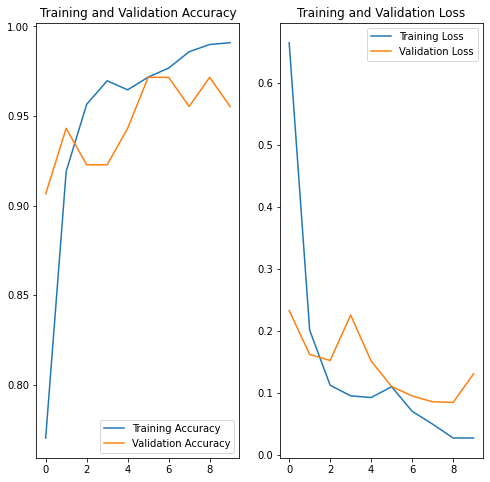

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.save('modelo.h5')

## Predicciones con dataset de testeo

In [23]:
eye_url = '/test_eyes/Open/_24.jpg'
eye_path = tf.keras.utils.get_file('Opened_eye', origin=eye_url)

img = tf.keras.utils.load_img(
    eye_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

ValueError: ignored